# Context
This notebook drives the training process for different models.

# Context
This notebook drives the training process for different models.

In [8]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [9]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup
from TRAIN.architecture.archeader import bert

In [10]:
TRAIN_classes = 'two-classes'
tinybert_ahpf_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_AH_PF, bert.BERT_TINY,"2025-06-09_02:13:17.csv")
tinybert_spf_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PF, bert.BERT_TINY,"2025-06-09_02:19:29.csv")
tinybert_spv_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PV, bert.BERT_TINY,"2025-06-09_02:22:16.csv")
distilbert_ahpf_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_AH_PF, bert.DISTILBERT,"2025-06-09_01:40:12.csv")
distilbert_spf_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PF, bert.DISTILBERT,"2025-06-09_01:48:17.csv")
distilbert_spv_score_file = os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PV, bert.DISTILBERT,"2025-06-09_02:00:41.csv")

top_barrier=3

# Score analysis

## Helper functions

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [12]:
def visualize(df, group_cols, top, filter_cols=None, filter_values=None):
    """
    Optionally filters df by filter_cols == filter_values, groups by group_cols,
    selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
    """
    filter_desc = ""

    # Filter if needed
    if filter_cols and filter_values:
        for col, val in zip(filter_cols, filter_values):
            df = df[df[col] == val]
        filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

    # Group, take top `top` by accuracy, compute mean
    mean_accuracies = (
        df.groupby(group_cols)
          .apply(lambda g: g.sort_values('accuracy', ascending=False).head(top)['accuracy'].mean())
          .reset_index(name='mean_accuracy')
    )

    # Create simple string labels for the x-axis
    mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

    # Plot
    colors = sns.color_palette("muted", len(mean_accuracies))
    plt.figure(figsize=(10, 6))
    plt.bar(mean_accuracies['label'], mean_accuracies['mean_accuracy'], color=colors)

    plt.ylabel(f"Mean Accuracy (Top {top})")
    plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
    plt.xticks(rotation=45, ha='right')

    # Set y-limits with padding
    min_val = mean_accuracies['mean_accuracy'].min()
    max_val = mean_accuracies['mean_accuracy'].max()
    padding = (max_val - min_val) * 0.3  # 10% padding
    plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

    # Add values on bars
    for i, val in enumerate(mean_accuracies['mean_accuracy']):
        plt.text(i, val + padding*0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


## Data

In [13]:
import pandas as pd

In [14]:
tinybert_ahpf_scores_df = pd.read_csv(tinybert_ahpf_score_file)
tinybert_spf_scores_df = pd.read_csv(tinybert_spf_score_file)
tinybert_spv_scores_df = pd.read_csv(tinybert_spv_score_file)
distilbert_ahpf_scores_df = pd.read_csv(distilbert_ahpf_score_file)
distilbert_spf_scores_df = pd.read_csv(distilbert_spf_score_file)
distilbert_spv_scores_df = pd.read_csv(distilbert_spv_score_file)

bert_scores_df = pd.concat([tinybert_ahpf_scores_df, tinybert_spf_scores_df,
                            tinybert_spv_scores_df, distilbert_ahpf_scores_df,
                            distilbert_spf_scores_df, distilbert_spv_scores_df], 
                           ignore_index=True)


bert_scores_df = bert_scores_df.fillna('None')
bert_scores_df.sort_values(by="accuracy", ascending=False)

,class_list,accuracy,data_unit,PH2,PH3,reducer,kernel,n,loadable,lr,optimizer,loss_fn,num_epochs
32,two-classes,0.984032,AHpf,True,True,umap,None,11,distilbert-base-uncased,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),100
1,two-classes,0.984032,AHpf,True,True,umap,None,7,prajjwal1/bert-tiny,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),1000
2,two-classes,0.983034,AHpf,True,True,umap,None,11,prajjwal1/bert-tiny,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),1000
34,two-classes,0.982036,AHpf,True,False,None,None,-1,distilbert-base-uncased,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),100
33,two-classes,0.980040,AHpf,True,True,umap,None,15,distilbert-base-uncased,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),100
31,two-classes,0.980040,AHpf,True,True,umap,None,7,distilbert-base-uncased,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),100
59,two-classes,0.976744,Spv,False,False,None,None,-1,distilbert-base-uncased,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),100
29,two-classes,0.976744,Spv,False,False,None,None,-1,prajjwal1/bert-tiny,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),1000
19,two-classes,0.976562,Spf,False,False,None,None,-1,prajjwal1/bert-tiny,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),1000
4,two-classes,0.975050,AHpf,True,False,None,None,-1,prajjwal1/bert-tiny,0.00001,AdamW (\nParameter Group 0\n amsgrad: False...,CrossEntropyLoss(),1000


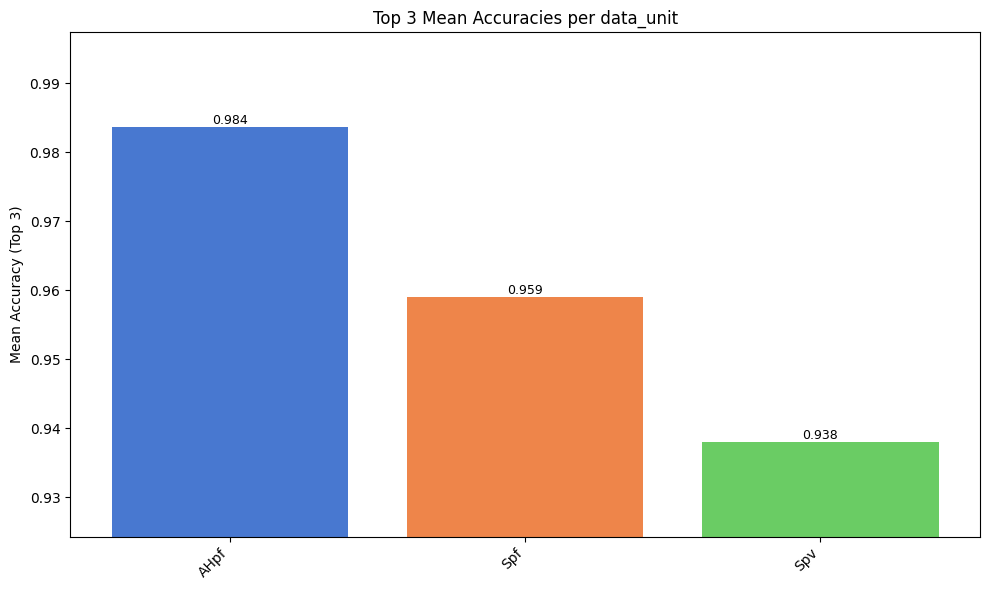

In [15]:
visualize(bert_scores_df, group_cols=['data_unit'], top=top_barrier)

### By data unit

#### Ahpf

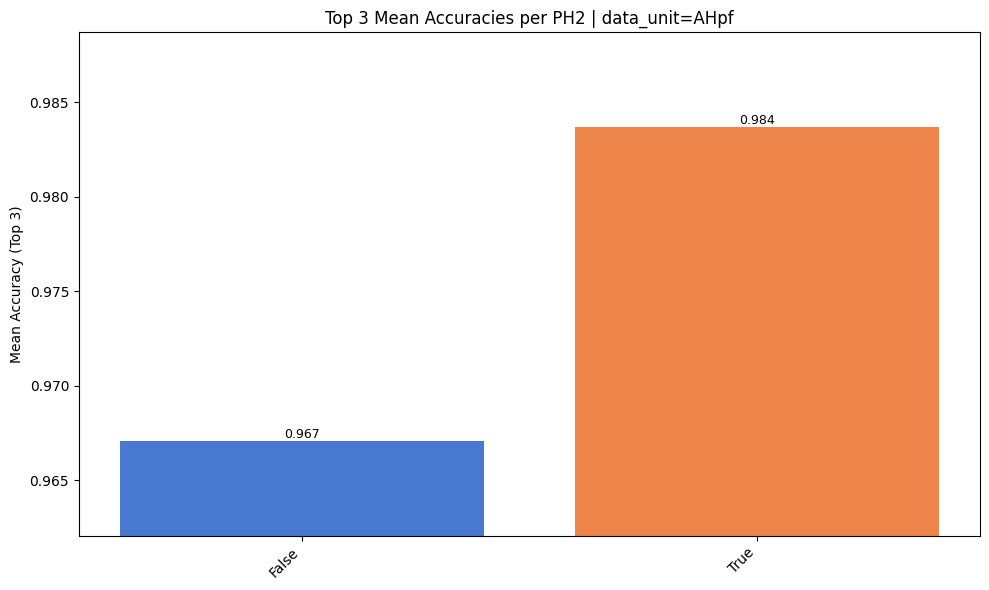

In [16]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

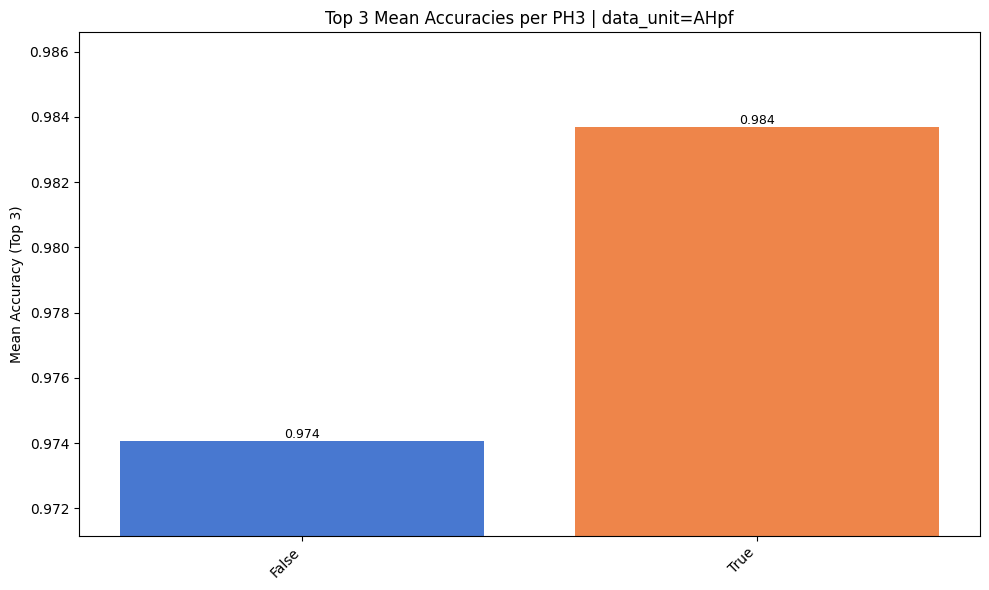

In [17]:
visualize(bert_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

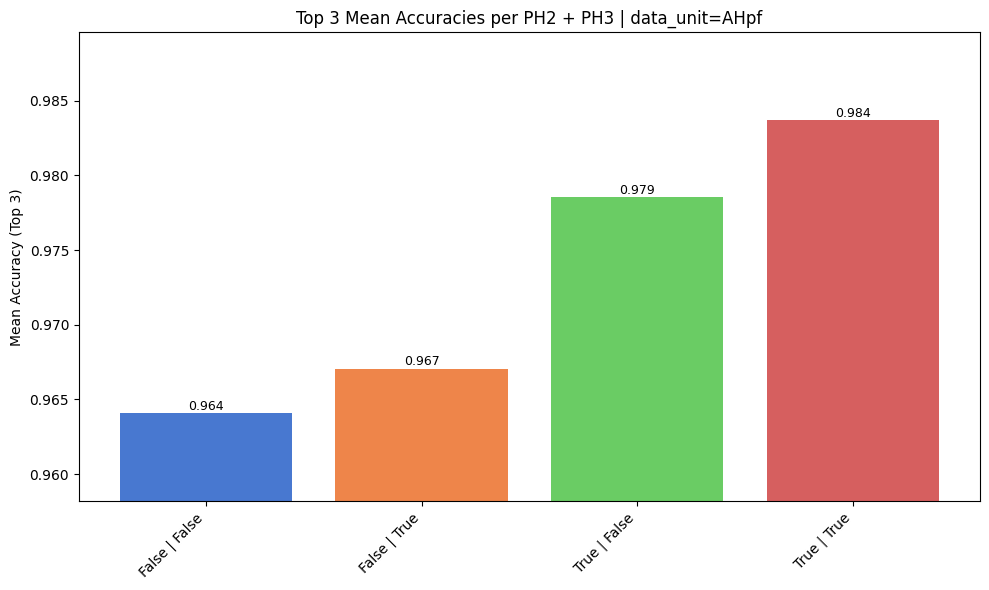

In [18]:
visualize(bert_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

#### Spf

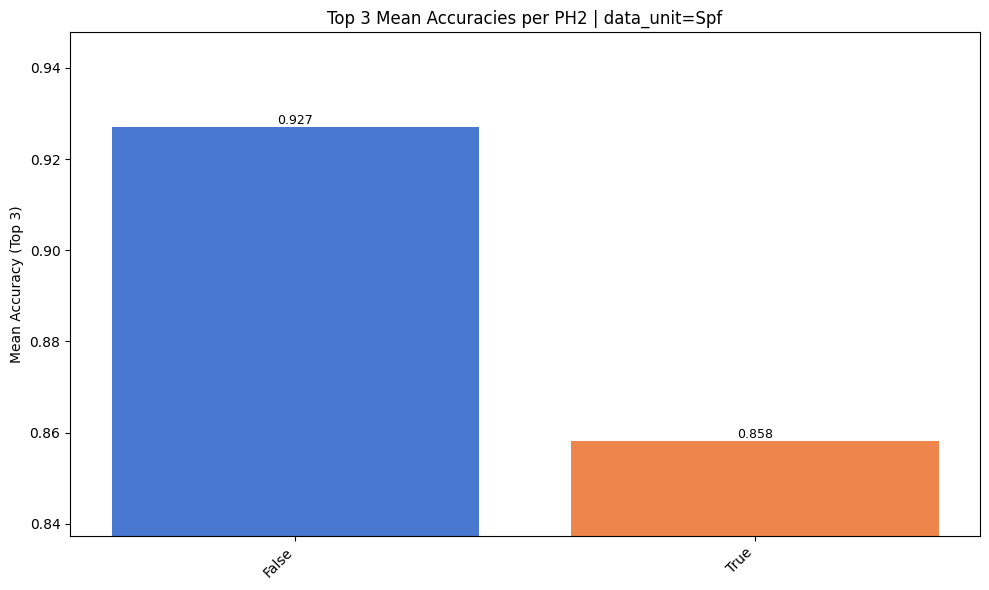

In [19]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

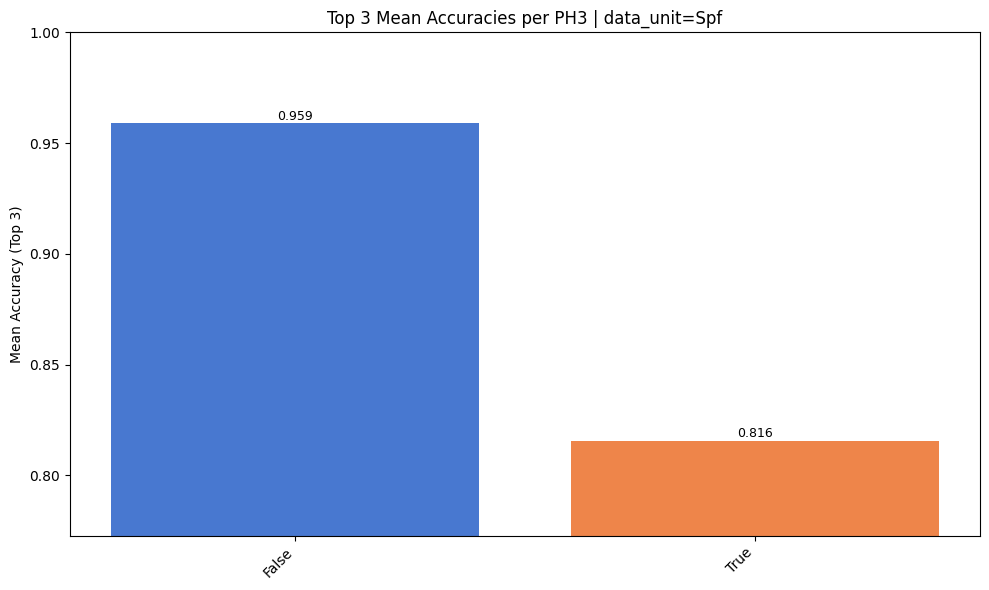

In [20]:
visualize(bert_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

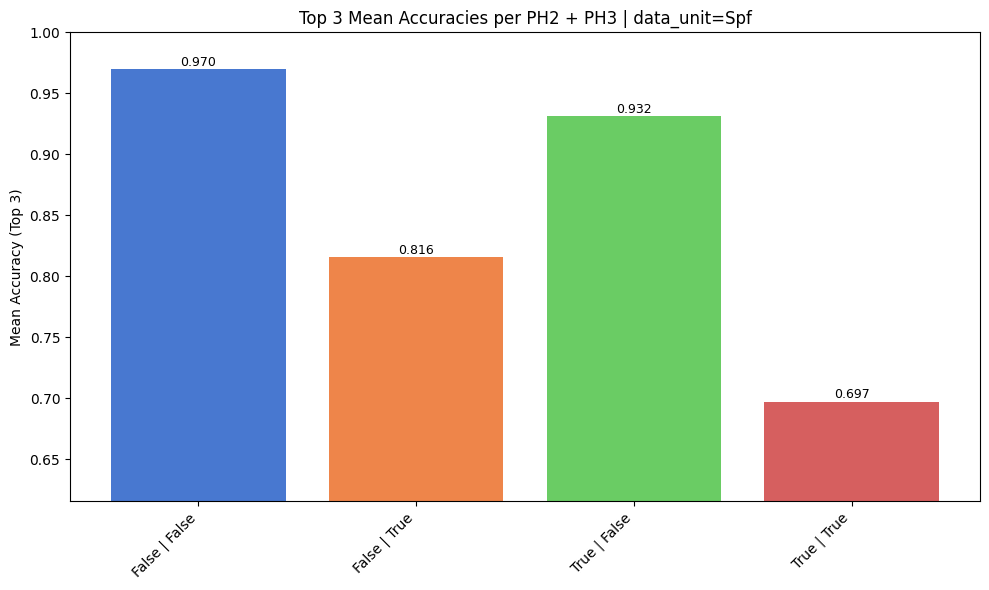

In [21]:
visualize(bert_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

#### Spv

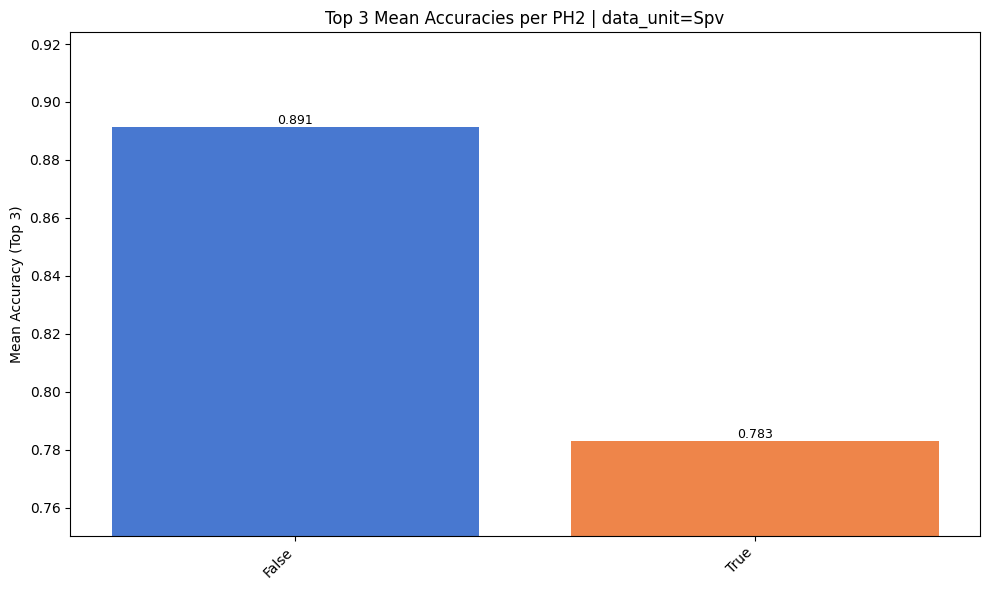

In [22]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

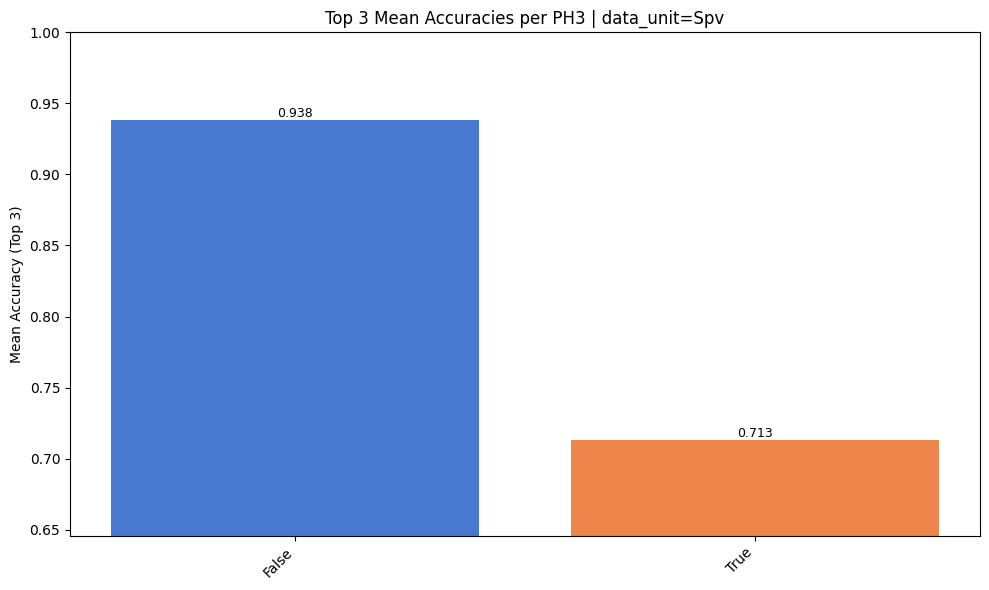

In [23]:
visualize(bert_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

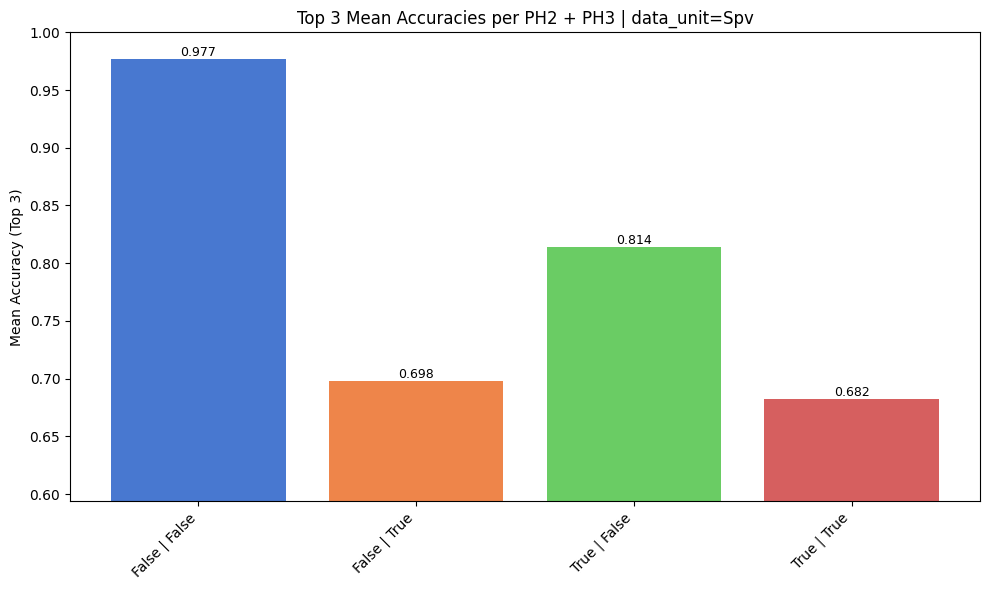

In [24]:
visualize(bert_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By reducer

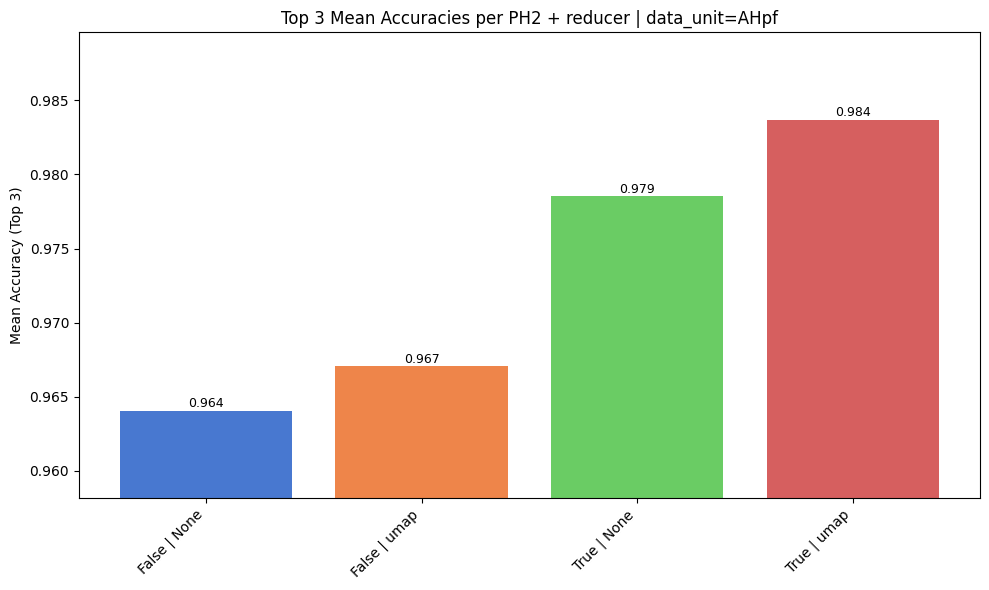

In [25]:
visualize(bert_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

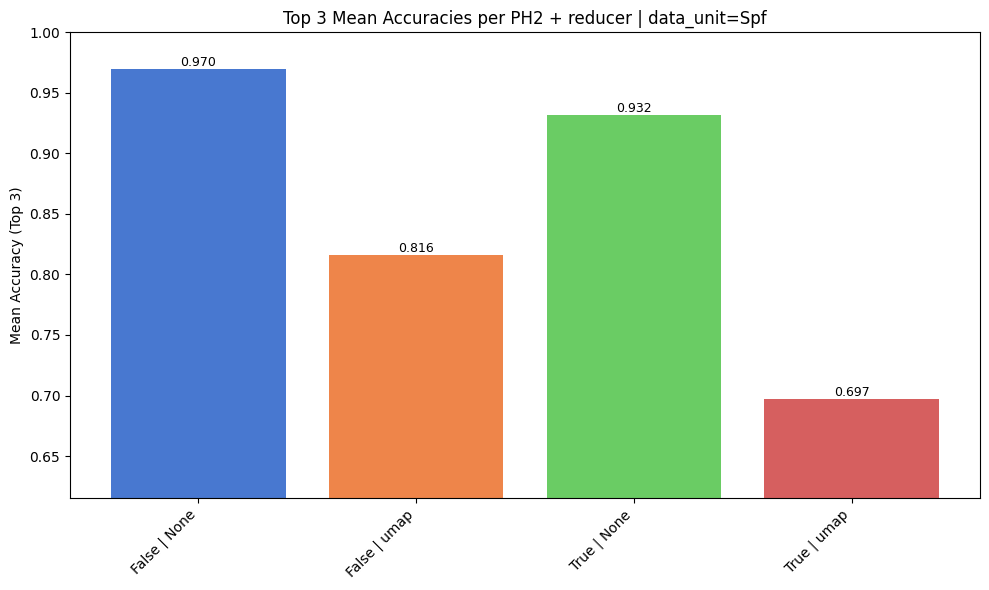

In [26]:
visualize(bert_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

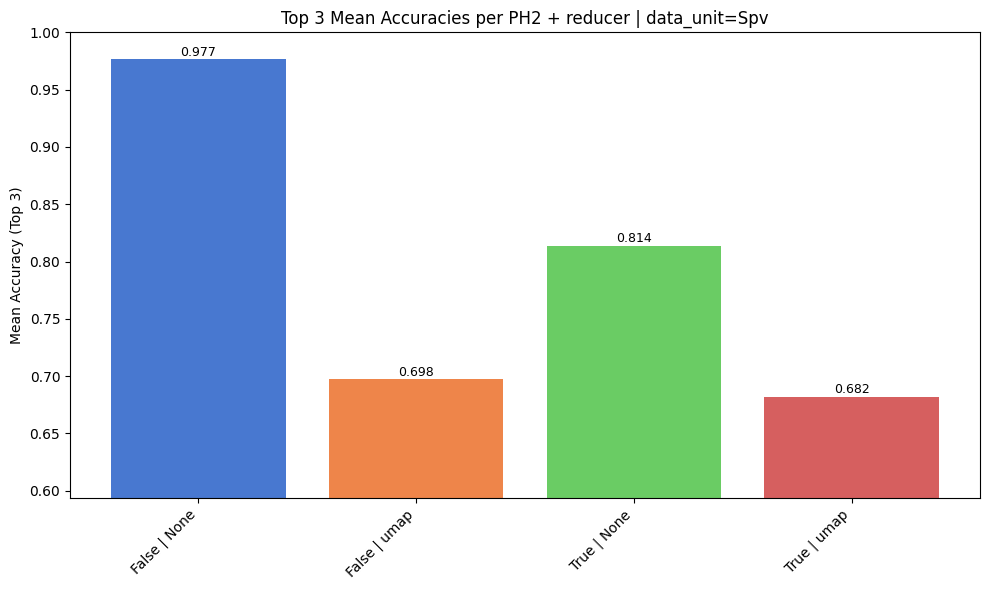

In [27]:
visualize(bert_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By number of reduction components

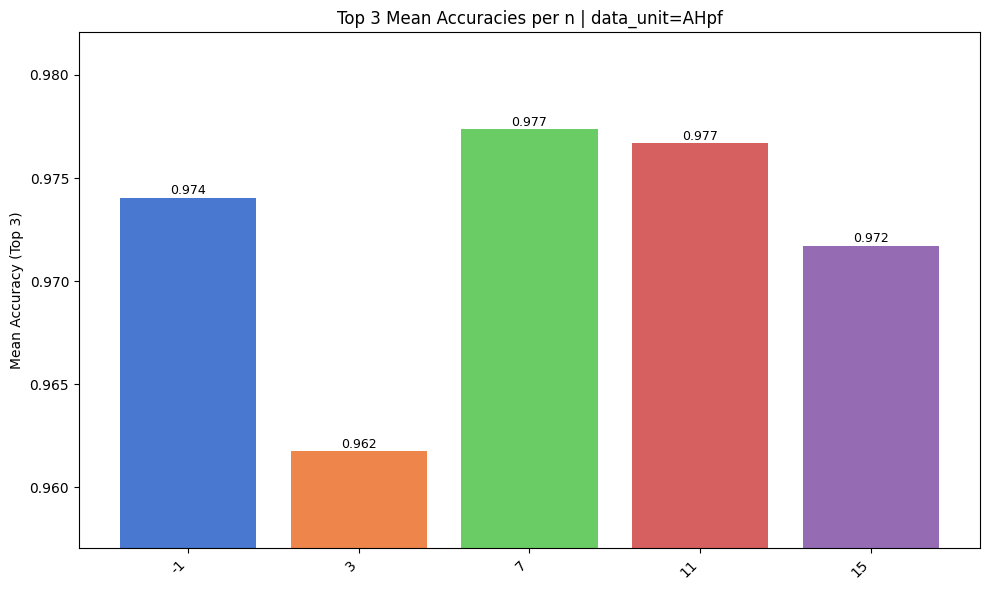

In [28]:
visualize(bert_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_AH_PF])

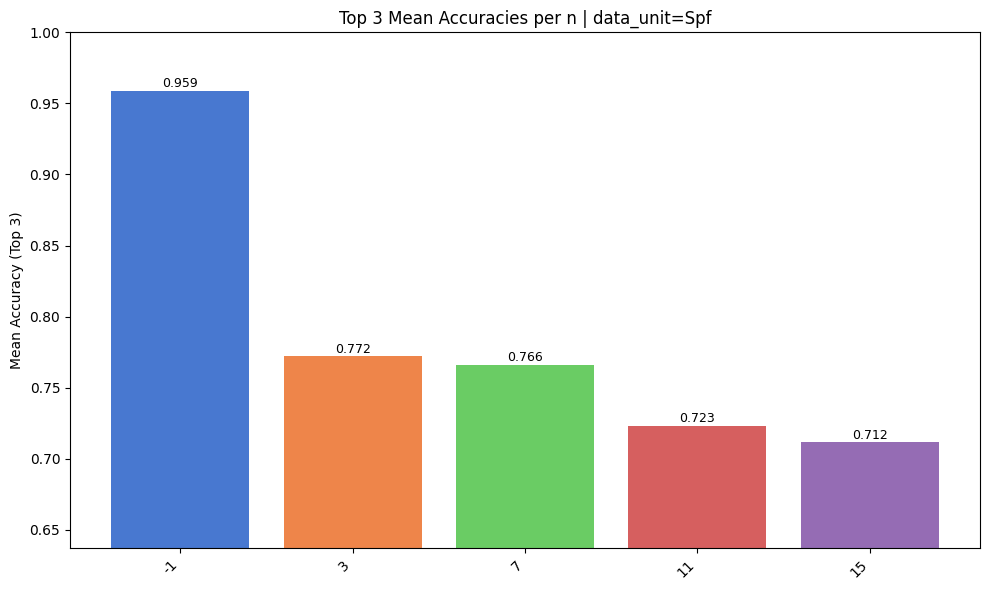

In [29]:
visualize(bert_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

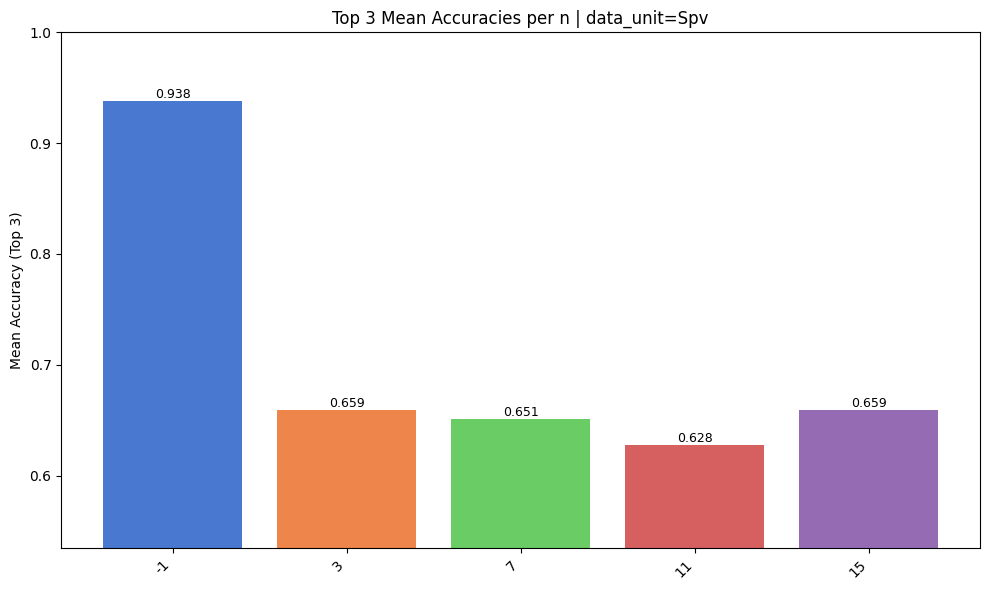

In [30]:
visualize(bert_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])